In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
plt.style.use(['seaborn-ticks'])
from pandas_profiling import ProfileReport

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# EDA

In [3]:
profile = ProfileReport(train, title="Pandas Profiling Report")
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/28 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

- Destination - Homeplanet
- Transported - CryoSleep

In [4]:
def preprocessing1(train,test):
    y=train['Transported'].copy().astype(int)
    X=train.drop('Transported', axis=1).copy()
    X["train-test"]=1
    test["train-test"]=0
    df=pd.concat([X, test], axis=0).reset_index(drop=True)

    #Filling the Na's to split
    df["Cabin"].fillna("ZZ/9999/ZZ", inplace = True)

    #Splitting
    df["Deck"] = df["Cabin"].apply(lambda x: x.split("/")[0])
    df["Num"] = df["Cabin"].apply(lambda x: x.split("/")[1])
    df["Side"] = df["Cabin"].apply(lambda x: x.split("/")[2])

    #Drop df["Cabin"]
    df.drop(["Cabin"], axis = 1, inplace = True)

    #Filling Na's
    df.loc[df["Deck"] == "ZZ", "Deck"] = np.nan
    df.loc[df["Side"] == "ZZ", "Side"] = np.nan 
    df.loc[df["Num"] == "9999", "Num"] = np.nan 

    #Split PassengerId to Group_size and Group
    df["Group"] = df["PassengerId"].apply(lambda x: x.split("_")[0]).astype("int")
    df["Group_size"] = df["PassengerId"].apply(lambda x: x.split("_")[1]).astype("int")

    #Solo
    df["Solo"] = df["Group_size"].apply(lambda x: 1 if x == 1 else 0)

    df["Name"].fillna("Missing Missing",inplace=True)
    df["Surname"] = df["Name"].apply(lambda x: x.split(" ")[1])
    df.drop(["Name"], axis = 1, inplace = True)

    df['Family_size']=df["Surname"].apply(lambda x: df["Surname"].value_counts()[x]).astype(int)
    df.loc[df["Surname"] == "Missing", "Surname"] = np.nan
    df.loc[df['Family_size']>100,'Family_size'] = np.nan
    return df

In [5]:
df = preprocessing1(train,test)

In [6]:
df.head()

PassengerId HomePlanet CryoSleep  Destination   Age    VIP  RoomService  \
0     0001_01     Europa     False  TRAPPIST-1e  39.0  False          0.0   
1     0002_01      Earth     False  TRAPPIST-1e  24.0  False        109.0   
2     0003_01     Europa     False  TRAPPIST-1e  58.0   True         43.0   
3     0003_02     Europa     False  TRAPPIST-1e  33.0  False          0.0   
4     0004_01      Earth     False  TRAPPIST-1e  16.0  False        303.0   

   FoodCourt  ShoppingMall     Spa  VRDeck  train-test Deck Num Side  Group  \
0        0.0           0.0     0.0     0.0           1    B   0    P      1   
1        9.0          25.0   549.0    44.0           1    F   0    S      2   
2     3576.0           0.0  6715.0    49.0           1    A   0    S      3   
3     1283.0         371.0  3329.0   193.0           1    A   0    S      3   
4       70.0         151.0   565.0     2.0           1    F   1    S      4   

   Group_size  Solo      Surname  Family_size  
0           1     1    Ofracculy          3.0  
1           1     1        Vines          4.0  
2           1     1       Susent          7.0  
3           2     0       Susent          7.0  
4           1     1  Santantines          9.0

# HomePlanet

In [7]:
df.isna().sum()

PassengerId       0
HomePlanet      288
CryoSleep       310
Destination     274
Age             270
VIP             296
RoomService     263
FoodCourt       289
ShoppingMall    306
Spa             284
VRDeck          268
train-test        0
Deck            299
Num             299
Side            299
Group             0
Group_size        0
Solo              0
Surname         294
Family_size     294
dtype: int64

In [8]:
df_cat = ['HomePlanet', 'CryoSleep', 'Destination','VIP', 'Deck', 'Side', 'Group_size', 'Solo', 'Family_size']

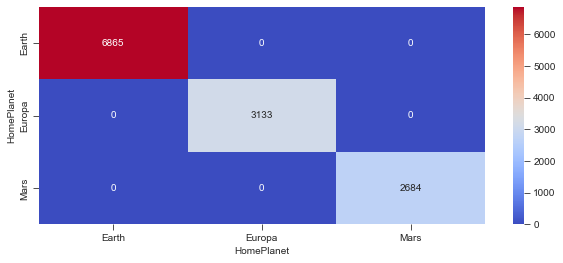

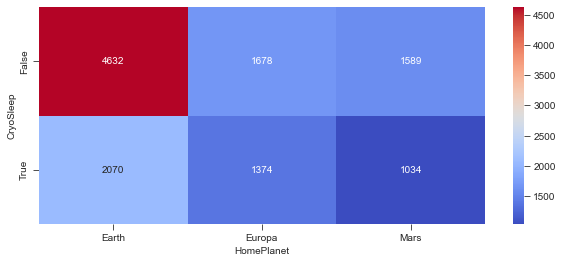

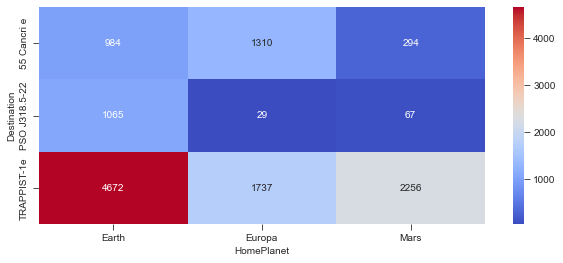

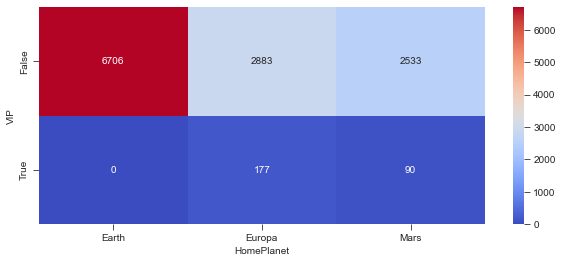

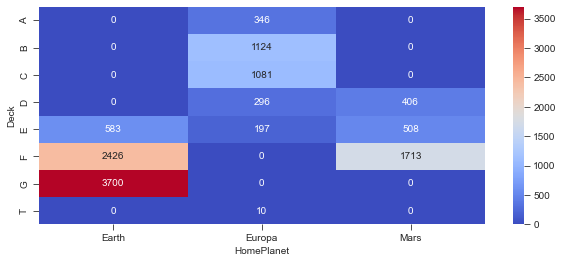

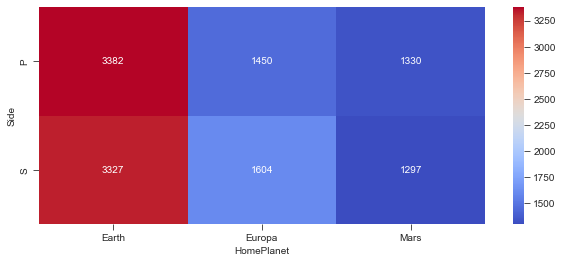

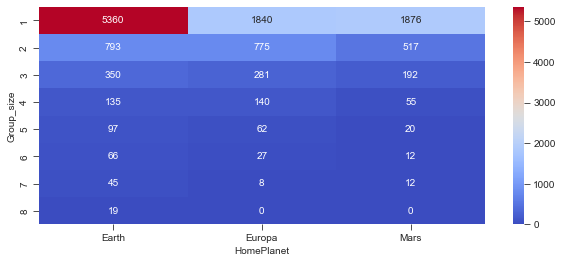

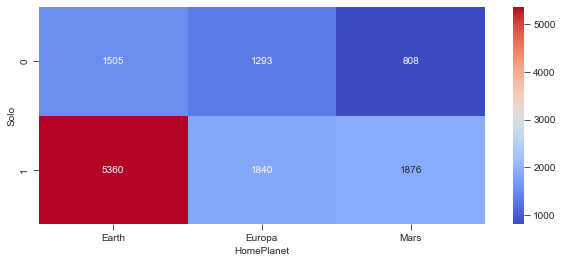

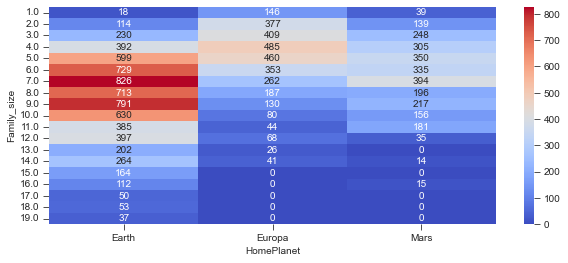

In [9]:
for i in range(len(df_cat)):
    group = df.groupby(['HomePlanet',df_cat [i]])[df_cat [i]].size().unstack().fillna(0)
    # Heatmap of missing values
    plt.figure(figsize=(10,4))
    sns.heatmap(group.T, annot=True, fmt='g', cmap='coolwarm')

In [10]:
GHP_gb=df.groupby(['Group','HomePlanet'])['HomePlanet'].size().unstack().fillna(0)
GHP_gb.head()

HomePlanet  Earth  Europa  Mars
Group                          
1             0.0     1.0   0.0
2             1.0     0.0   0.0
3             0.0     2.0   0.0
4             1.0     0.0   0.0
5             1.0     0.0   0.0

In [11]:
GHP_index=df[df['HomePlanet'].isna()][(df[df['HomePlanet'].isna()]['Group']).isin(GHP_gb.index)].index
df.loc[df['HomePlanet'].isna(),'HomePlanet'] = df.iloc[GHP_index,:]["Group"].apply(lambda x: GHP_gb.idxmax(axis=1)[x])

df.loc[(df["HomePlanet"].isna())& (df["Deck"].isin(['A', 'B', 'C', 'T'])), "HomePlanet"] = "Europa"
df.loc[(df["HomePlanet"].isna())& (df["Deck"].isin(['G'])), "HomePlanet"] = "Earth"

df.loc[(df['HomePlanet'].isna()) & ~(df['Deck']=='D'), 'HomePlanet']='Earth'
df.loc[(df['HomePlanet'].isna()) & (df['Deck']=='D'), 'HomePlanet']='Mars'

df['HomePlanet'].isna().sum()

0

# CryoSleep

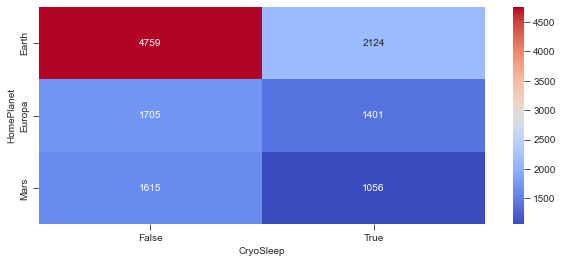

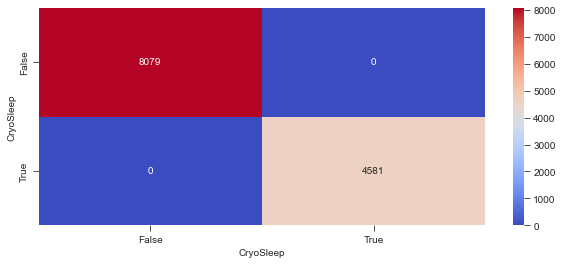

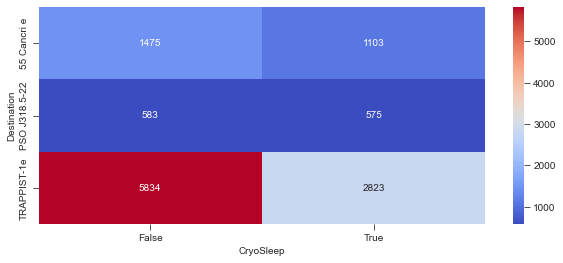

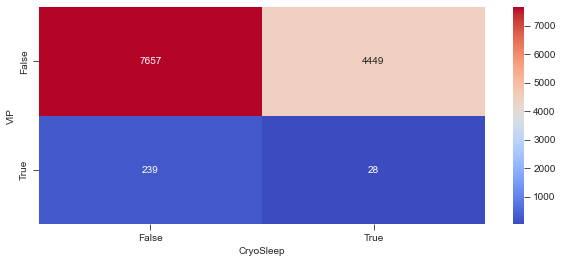

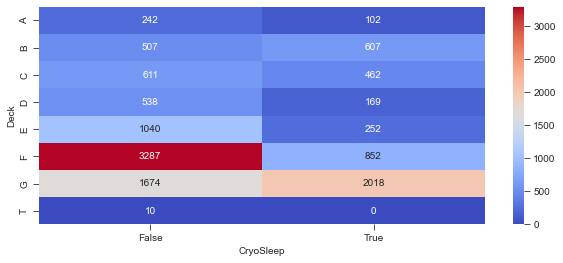

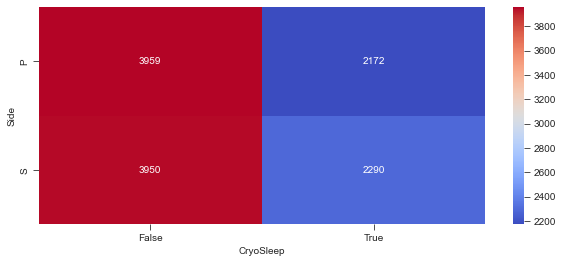

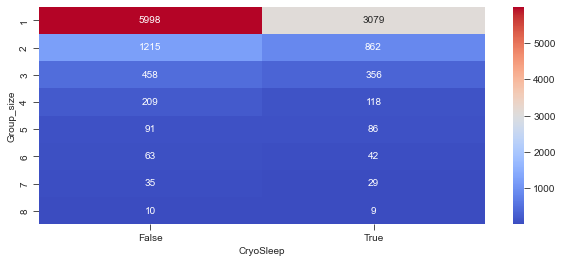

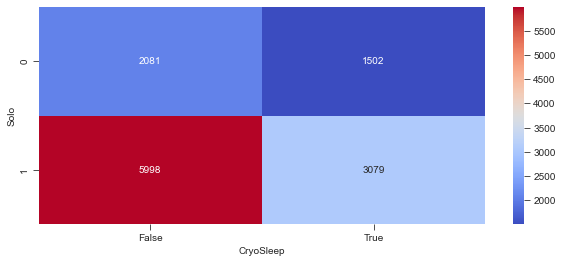

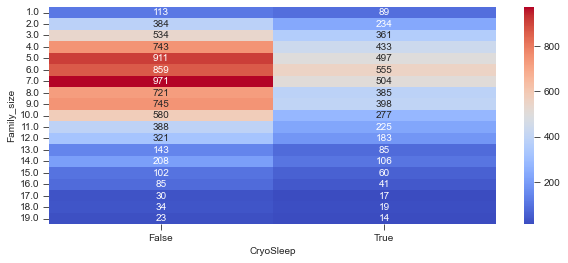

In [12]:
for i in range(len(df_cat)):
    group = df.groupby(['CryoSleep',df_cat [i]])[df_cat [i]].size().unstack().fillna(0)
    # Heatmap of missing values
    plt.figure(figsize=(10,4))
    sns.heatmap(group.T, annot=True, fmt='g', cmap='coolwarm')

In [13]:
df.loc[(df["RoomService"] == 0) & (df["CryoSleep"].isna()),"CryoSleep"] = True
df.loc[(df["FoodCourt"] == 0) & (df["CryoSleep"].isna()),"CryoSleep"] = True
df.loc[(df["ShoppingMall"] == 0) & (df["CryoSleep"].isna()),"CryoSleep"] = True
df.loc[(df["Spa"] == 0) & (df["CryoSleep"].isna()),"CryoSleep"] = True

df.loc[(df["RoomService"] > 0) & (df["CryoSleep"].isna()),"CryoSleep"] = False
df.loc[(df["FoodCourt"] > 0) & (df["CryoSleep"].isna()),"CryoSleep"] = False
df.loc[(df["ShoppingMall"] > 0) & (df["CryoSleep"].isna()),"CryoSleep"] = False
df.loc[(df["Spa"] > 0) & (df["CryoSleep"].isna()),"CryoSleep"] = False

In [14]:
df["CryoSleep"].isna().sum()

0

In [15]:
df.isna().sum()

PassengerId       0
HomePlanet        0
CryoSleep         0
Destination     274
Age             270
VIP             296
RoomService     263
FoodCourt       289
ShoppingMall    306
Spa             284
VRDeck          268
train-test        0
Deck            299
Num             299
Side            299
Group             0
Group_size        0
Solo              0
Surname         294
Family_size     294
dtype: int64

# Age

In [16]:
df["Age"].fillna(df["Age"].mean(),inplace = True)

In [17]:
df["Age"].isna().sum()

0

# Destination

In [18]:
df.loc[(df['Destination'].isna()), 'Destination']='TRAPPIST-1e'

# VIP

In [19]:
df["VIP"].fillna(False,inplace = True)

# Consumption

In [20]:
df["RoomService"].fillna(df["RoomService"].mean(), inplace = True), 
df["FoodCourt"].fillna(df["FoodCourt"].mean(),inplace = True)
df["ShoppingMall"].fillna(df["ShoppingMall"].mean(),inplace = True)
df["Spa"].fillna(df["Spa"].mean(),inplace = True)
df["VRDeck"].fillna(df["VRDeck"].mean(),inplace = True)
df["consumption"] = df["RoomService"] + df["FoodCourt"] + df["ShoppingMall"] + df["Spa"] + df["VRDeck"]

# Surname

In [21]:
SG_gb=df[df['Group_size']>1].groupby(['Group','Surname'])['Surname'].size().unstack().fillna(0)

In [22]:
SG_index=df[df['Surname'].isna()][(df[df['Surname'].isna()]['Group']).isin(SG_gb.index)].index
df.loc[df['Surname'].isna(),'Surname'] = df.iloc[SG_index,:]["Group"].apply(lambda x: SG_gb.idxmax(axis=1)[x])

In [23]:
df['Surname'].fillna('Unknown', inplace=True)

# Update family size feature
df['Family_size']=df['Surname'].map(lambda x: df['Surname'].value_counts()[x])

# Put NaN's back in place of outliers
df.loc[df['Surname']=='Unknown','Surname']=np.nan

# Say unknown surname means no family
df.loc[df['Family_size']>100,'Family_size']=0

# Deck

In [24]:
na_rows_CD=df.loc[df['Deck'].isna(),'Deck'].index
df.loc[df['Deck'].isna(),'Deck']=df.groupby(['HomePlanet','Destination','Solo'])['Deck'].transform(lambda x: x.fillna(pd.Series.mode(x)[0]))[na_rows_CD]

# Cabin Number

Text(0.5, 1.0, 'Cabin_number vs group coloured by group')

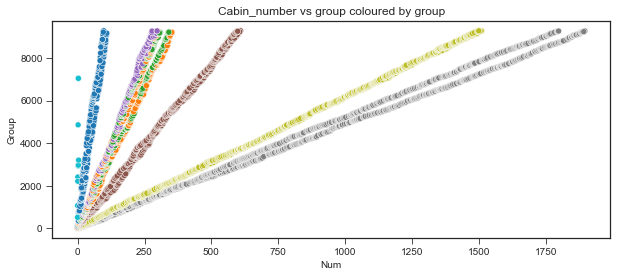

In [25]:
from sklearn.preprocessing import LabelEncoder
plt.figure(figsize=(10,4))
sns.scatterplot(x=df['Num'].astype(float), y=df['Group'], c=LabelEncoder().fit_transform(df.loc[~df['Num'].isna(),'Deck']), cmap='tab10')
plt.title('Cabin_number vs group coloured by group')

In [26]:
from sklearn.svm import SVC

for i in ['B', 'C', 'F', 'G']:

    X_CN =       df.loc[~(df['Num'].isna()) & (df['Deck']==i),'Group'].astype(float)
    y_CN =       df.loc[~(df['Num'].isna()) & (df['Deck']==i),'Num'].astype(float)
    X_test_CN =  df.loc[(df['Num'].isna()) & (df['Deck']==i),'Group'].astype(float)

    CN_model = SVC(kernel="linear")
    CN_model.fit(X_CN.values.reshape(-1,1),y_CN.values.reshape(-1,1))

    CN_pred=CN_model.predict(X_test_CN.values.reshape(-1, 1))
    
    # Fill missing values with predictions
    df.loc[(df['Num'].isna()) & (df['Deck']==i),'Num']=CN_pred.astype(int)
    print(i)

/Users/efedilaver/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


B


/Users/efedilaver/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


C


/Users/efedilaver/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


F


/Users/efedilaver/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


G


In [27]:
df = df.copy()

# Side

In [28]:
SCS_gb=df[df['Group_size']>1].groupby(['Surname','Side'])['Side'].size().unstack().fillna(0)
# Passengers with missing Cabin side and in a family with known Cabin side
SCS_index=df[df['Side'].isna()][(df[df['Side'].isna()]['Surname']).isin(SCS_gb.index)].index

# Fill corresponding missing values
df.loc[SCS_index,'Side']=df.iloc[SCS_index,:]['Surname'].map(lambda x: SCS_gb.idxmax(axis=1)[x])

# Drop surname (we don't need it anymore)
df.drop('Surname', axis=1, inplace=True)

# Fill remaining missing values with outlier
df.loc[df['Side'].isna(),'Side']='Z'

# Labeling

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from matplotlib import pyplot as plt 
import seaborn as sns

In [30]:
# One-hot encode cabin regions
df["Num"]=df["Num"].astype(int)
df['Cabin_region1']=(df['Num']<300).astype(int)
df['Cabin_region2']=((df['Num']>=300) & (df['Num']<600)).astype(int)
df['Cabin_region3']=((df['Num']>=600) & (df['Num']<900)).astype(int)
df['Cabin_region4']=((df['Num']>=900) & (df['Num']<1200)).astype(int)
df['Cabin_region5']=((df['Num']>=1200) & (df['Num']<1500)).astype(int)
df['Cabin_region6']=((df['Num']>=1500) & (df['Num']<1800)).astype(int)
df['Cabin_region7']=(df['Num']>=1800).astype(int)


In [36]:
X_train = df.loc[df["train-test"]==1,:]
X_test = df.loc[df["train-test"]==0,:]
X_train.drop(['PassengerId', 'Group', 'Group_size', 'Num', 'train-test'], axis=1, inplace=True)
X_test.drop(['PassengerId', 'Group', 'Group_size', 'Num', 'train-test'], axis=1, inplace=True)

/var/folders/jj/s4q9myv17_lf_b824yx79tz40000gn/T/ipykernel_7505/3090046378.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.drop(['PassengerId', 'Group', 'Group_size', 'Num', 'train-test'], axis=1, inplace=True)
/var/folders/jj/s4q9myv17_lf_b824yx79tz40000gn/T/ipykernel_7505/3090046378.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.drop(['PassengerId', 'Group', 'Group_size', 'Num', 'train-test'], axis=1, inplace=True)


In [37]:
# Apply log transform
for i in ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','consumption']:
    X_train.loc[:,i]=np.log(1+X_train.loc[:,i])
    X_test.loc[:,i]=np.log(1+X_test.loc[:,i])

/var/folders/jj/s4q9myv17_lf_b824yx79tz40000gn/T/ipykernel_7505/3280302652.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.loc[:,i]=np.log(1+X_train.loc[:,i])
/var/folders/jj/s4q9myv17_lf_b824yx79tz40000gn/T/ipykernel_7505/3280302652.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.loc[:,i]=np.log(1+X_test.loc[:,i])


In [38]:
NumCol = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Family_size', 'consumption']
CatCol = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'Side', 'Solo']
numerical_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(drop='if_binary', handle_unknown='ignore',sparse=False))])

ct = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, NumCol),
        ('cat', categorical_transformer, CatCol)],
        remainder='passthrough')

# Apply preprocessing
X_train = ct.fit_transform(X_train)
X_test = ct.transform(X_test)

# Print new shape
print('Training set shape:', X_train.shape)

Training set shape: (8693, 35)


In [42]:
y=train['Transported'].copy().astype(int)
X_train, X_valid, y_train, y_valid = train_test_split(X_train,y,stratify=y,train_size=0.8,test_size=0.2,random_state=0)

# Modelling

In [43]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

In [44]:
model = GridSearchCV(
    estimator=XGBClassifier(random_state=0, use_label_encoder=False, eval_metric='logloss'), 
    param_grid= {'n_estimators': [50, 100, 150, 200], 'max_depth': [4, 8, 12], 'learning_rate': [0.05, 0.1, 0.15]}, 
    n_jobs=-1, 
    cv=4
)


In [45]:
model.fit(X_train,y_train)
print(model.score(X_valid, y_valid))
print(model.best_params_)

/Users/efedilaver/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/efedilaver/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/efedilaver/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/efedilaver/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in

0.79700977573318
{'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 200}


# Save Model

In [46]:
import pickle

with open('xgboost.pkl', 'wb') as f: 
  pickle.dump(model, f)

with open('xgboost.pkl', 'rb') as f: 
  reloaded_model = pickle.load(f)

In [52]:
y_test = reloaded_model.predict(X_test)

# Prediction

In [59]:
sub=pd.read_csv('sample_submission.csv')

# Add predictions
sub['Transported']=y_test

# Replace 0 to False and 1 to True
sub=sub.replace({0:False, 1:True})

sub.to_csv('submission.csv', index=False)